Is distance really confounding?
Add race

Arc:
* Single variable
* Relationships
* Confounders


In [1]:
import cartopy.io.shapereader as shpreader
from datetime import datetime
from descartes import PolygonPatch
import fiona
import math
import matplotlib as mpl
from matplotlib.collections import PatchCollection
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as spstats
import shapefile
from shapely.geometry import MultiPoint, MultiPolygon, Point, shape
import sys
from tqdm import tqdm

%matplotlib inline


## Load Data

#### Load American Community Survey Data

In [2]:
df_census_raw = pd.read_csv('census.tsv', delimiter='\t')
df_census_raw['index'] = df_census_raw.FIPS
df_census_raw = df_census_raw.set_index('index')

In [3]:
# Create data frame of just the data we need
df = pd.DataFrame(index=df_census_raw.index)
df['FIPS'] = df_census_raw['FIPS']
df['income'] = df_census_raw['Families: Median Family Income in the Past 12 Months (In 2016 Inflation-Adjusted Dollars)']
df['population'] = df_census_raw['Total Population']
df['white'] = df_census_raw['Population of One Race: White']
df['white_frac'] = df['white'] / df['population']

df_census = df.dropna()

#### Load Taxi Trip Data

In [4]:
df_yellow = pd.read_csv('taxi/yellow_tripdata_2017-01.csv')
df_green = pd.read_csv('taxi/green_tripdata_2017-01.csv')
df_taxi = pd.concat([df_yellow, df_green])

#### Load NYC Taxi Zones

In [5]:
# Helper functions

def log_ticks(low, high):
    lowexp = math.floor(low)
    highexp = math.ceil(high)
    ticks = []
    labels = []
    for e in range(lowexp, highexp + 1):
        for i in range(1, 10):
            v = i * 10**e
            logv = np.log10(v)
            if logv > lowexp and logv < highexp:
                ticks.append(logv)
                labels.append(v)
            if highexp - lowexp > 2:
                break
    return ticks, labels

def plot_geo_values(zones, key=None, label=None, transform=None):
    if transform is None:
        tf = lambda x: x
        itf = lambda x: x
    elif transform == 'log':
        tf = np.log10
        itf = lambda x: np.power(10, x)
    if key is not None:
        values = [r.attributes[key] for r in zones]
        if transform == 'log':
            # Drop zeros for log transform
            values = [v for v in values if v > 0]
        count_max, count_min = tf(max(values)), tf(min(values))
        count_span = count_max - count_min
    patches = []
    cm = plt.get_cmap('Blues')
    for record in zones:
        if key is not None:
            try:
                raw_value = record.attributes[key]
                if transform == 'log' and raw_value == 0:
                    # Skip 0 values for log
                    continue
                value = tf(raw_value)
            except KeyError:
                if transform == 'log':
                    continue
                else:
                    value = 0
            color = cm((value - count_min) / count_span)
        else:
            color = "#efefef"
        patch = PolygonPatch(record._geometry, fc=color, ec='#555555', lw=0.2, alpha=1, zorder=1)
        patches.append(patch)

    mp = MultiPolygon([
        shape(record._geometry)
        for record in zones])
    minx, miny, maxx, maxy = mp.bounds
    w, h = maxx - minx, maxy - miny
    aspect = w / h

    fig = plt.figure(figsize=(8 * aspect / 0.9, 8))
    ax = fig.add_subplot(111)
    ax.set_xlim(minx - 0.2 * w, maxx + 0.2 * w)
    ax.set_ylim(miny - 0.2 * h, maxy + 0.2 * h)
    ax.set_aspect(1)
    ax.add_collection(PatchCollection(patches, match_original=True))
    
    if key is not None:
        # Add colorbar
        plt.subplots_adjust(right=0.9)
        cax = plt.axes([0.95, 0.1, 0.035, 0.8])
        norm = mpl.colors.Normalize(vmin=count_min, vmax=count_max)
        cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cm,
                                        norm=norm,
                                        orientation='vertical')
        if label is not None:
            cb1.set_label(label)
        else:
            cb1.set_label(key)
        if transform == 'log':
            ticks, labels = log_ticks(count_min, count_max)
            cb1.set_ticks(ticks)
            cb1.set_ticklabels(labels)

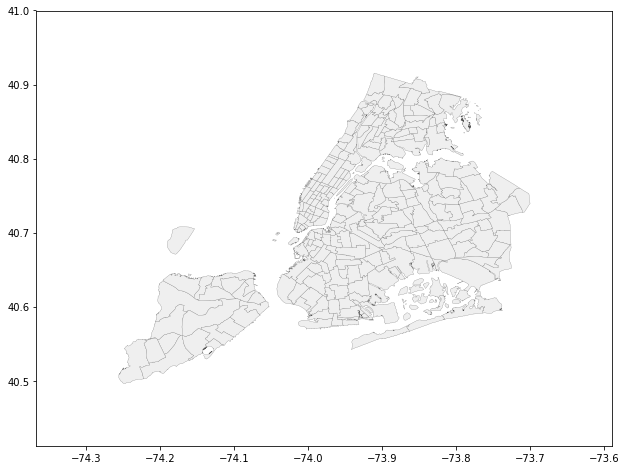

In [6]:
reader = shpreader.Reader('taxi/taxi_zones/taxi_zones-latlong.shp')
taxi_geo = list(reader.records())
plot_geo_values(taxi_geo)

#### Load Census Tracts

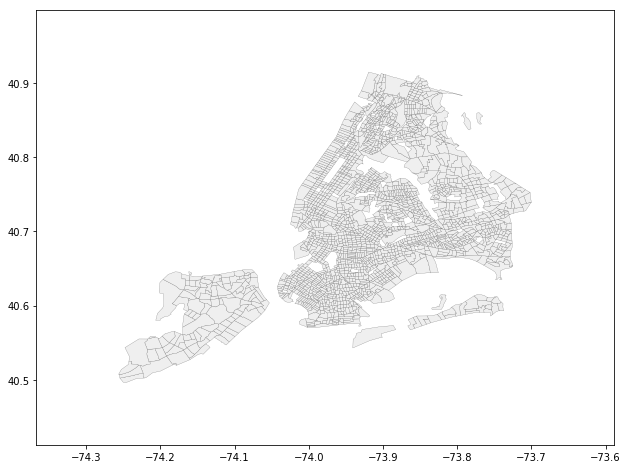

In [7]:
reader = shpreader.Reader('tracts/cb_2017_36_tract_500k.shp')
tract_geo = list(reader.records())

# Keep tracts in NYC
geoids = set(df_census['FIPS'])
tract_geo = [
    record for record in tract_geo
    if int(record.attributes['GEOID']) in geoids]

plot_geo_values(tract_geo)

## Visualize Data
#### Visualize Trips

In [8]:
# Helper functions

def annotate_records(records, data, key):
    for r in records:
        geoid = int(r.attributes['GEOID'])
        r.attributes[key] = data[geoid]

def update_counts(df, records):
    print('Updating counts')
    counts_pickup = df.groupby('PULocationID').count()['VendorID']
    counts_dropoff = df.groupby('DOLocationID').count()['VendorID']
    zone_pu_counts = {}
    zone_do_counts = {}
    for zone, count in dict(counts_pickup).items():
        zone_pu_counts[zone] = count
    for zone, count in dict(counts_dropoff).items():
        zone_do_counts[zone] = count
    for r in records:
        geoid = r.attributes['LocationID']
        r.attributes['pickups'] = zone_pu_counts.get(geoid, 0)    
        r.attributes['dropoffs'] = zone_do_counts.get(geoid, 0)    


In [9]:
update_counts(df_taxi, taxi_geo)

Updating counts


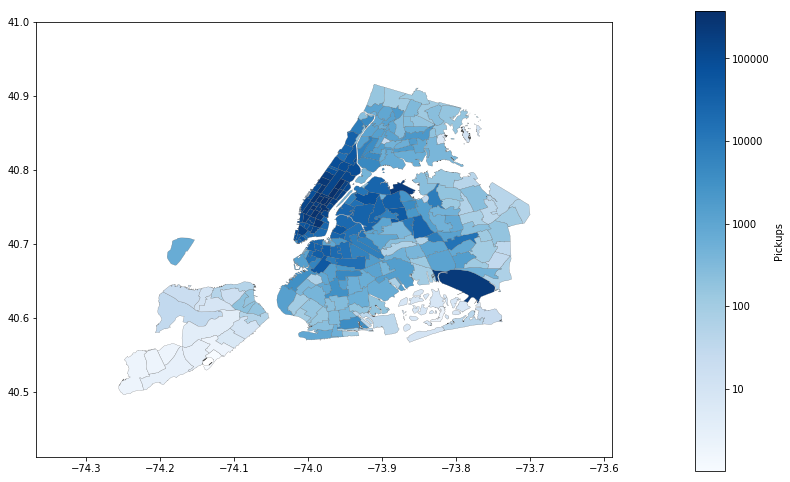

In [10]:
plot_geo_values(taxi_geo, 'pickups', 'Pickups', transform='log')

#### Remove Airports

/Users/elplatt/science3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Updating counts


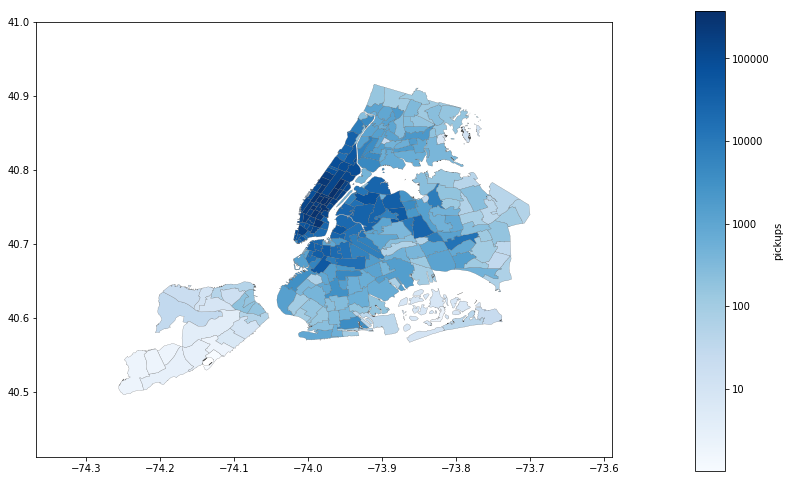

In [11]:
airports = [r for r in taxi_geo if 'Airport' in r.attributes['zone']]
airport_zones = [r.attributes['zone'] for r in airports]

# Remove airports zones and trips
taxi_geo = [r for r in taxi_geo if 'Airport' not in r.attributes['zone']]
df_taxi = df_taxi[
    (~df_taxi['DOLocationID'].isin(airport_zones))
    & (~df_taxi['PULocationID'].isin(airport_zones))]

# Update counts and plot
update_counts(df_taxi, taxi_geo)
plot_geo_values(taxi_geo, 'pickups', transform='log')

#### Visualize income

In [12]:
# Helper functions

# Get geoid->values from df for each element in geo
def get_geo_map(df, key, geo):
    result = {}
    for i, r in enumerate(geo):
        geoid = int(r.attributes['GEOID'])
        result[geoid] = df.loc[geoid, key]
    return result

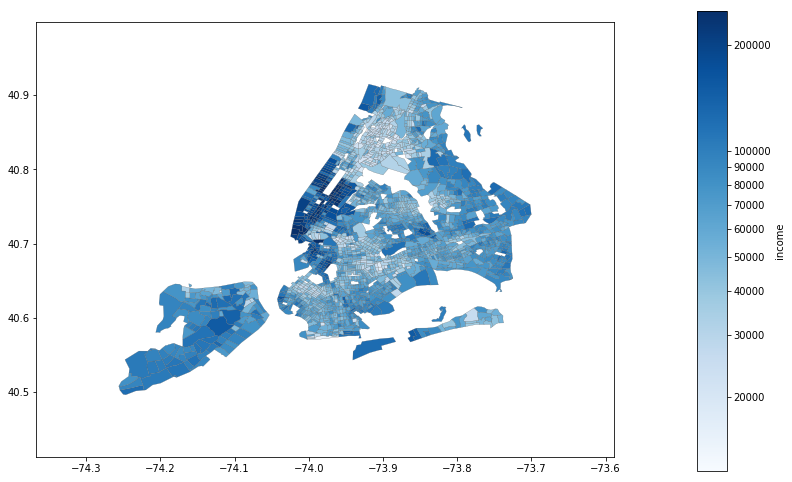

In [13]:
tract_income_map = get_geo_map(df_census, 'income', tract_geo)
tract_log_incomes = dict((k, np.log10(v)) for k, v in tract_income_map.items())
annotate_records(tract_geo, tract_income_map, 'income')
plot_geo_values(tract_geo, 'income', transform='log')

## Pairwise Trip Data
#### Create data frame for pairwise data

In [14]:
# Helper functions

def make_pair_df(geo):
    index = set([
        (r.attributes['LocationID'], s.attributes['LocationID'])
        for r in geo
        for s in geo
        if r.attributes['LocationID'] != s.attributes['LocationID']
    ])
    df_pairs = pd.DataFrame(index=list(index))
    return df_pairs

def plot_pairs(
    geo,
    df_pairs,
    key,
    label=None,
    bounds=None,
    threshold=0,
    transform=None,
    linewidth=0.1,
    alpha=0.3
):
    points = {}
    patches = []
    print('Finding representative points')
    sys.stdout.flush()
    for record in tqdm(geo):
        patch = PolygonPatch(record._geometry, fc='#efefef', ec='#555555', lw=0.2, alpha=1, zorder=1)
        patches.append(patch)
        record_id = record.attributes['LocationID']
        points[record_id] = record._geometry.representative_point().coords[0]

    mp = MultiPolygon([
        shape(record._geometry)
        for record in geo])
    minx, miny, maxx, maxy = mp.bounds
    w, h = maxx - minx, maxy - miny

    if bounds is None:
        xlim = (minx - 0.2 * w, maxx + 0.2 * w)
        ylim = (miny - 0.2 * h, maxy + 0.2 * h)
    else:
        xlim = (bounds[0], bounds[1])
        ylim = (bounds[2], bounds[3])
    ar = (xlim[1] - xlim[0]) / (ylim[1] - ylim[0])
    
    fig = plt.figure(figsize=(8 * ar, 8))
    ax = fig.add_subplot(111)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.add_collection(PatchCollection(patches, match_original=True))
    
    if transform is None:
        tf = lambda x: x
        itf = lambda x: x
    if transform == 'log':
        tf = np.log10
        itf = lambda x: np.power(10, x)
        
    trip_max = tf(df_pairs['trips'].max())
    
    cm = plt.get_cmap('afmhot')
    sys.stdout.flush()
    print('Drawing lines')
    sys.stdout.flush()
    for a_id, b_id in tqdm(df_pairs.index):
        a_point = points[a_id]
        b_point = points[b_id]
        try:
            raw_count = df_pairs['trips'][(a_id, b_id)]
            try:
                if raw_count < threshold:
                    continue
            except ValueError:
                print("raw", raw_count, 't', threshold, 'a', a_id, 'b', b_id)
                raise
            count = tf(raw_count)
            f = count / trip_max
            color = "#000000"
            l = mlines.Line2D(
                [a_point[0], b_point[0]],
                [a_point[1], b_point[1]],
                color='#000000',
                linewidth=linewidth,
                alpha=f*alpha)
            ax.add_line(l)
        except RuntimeError:
            pass

In [15]:
df_pairs = make_pair_df(taxi_geo)

#### Count number of trips

In [16]:
# Helper function

# Calculate number of trips
def count_trips(df_taxi, df_pairs):
    print('Counting trips')
    index = df_pairs.index
    df_count = df_taxi.groupby(['PULocationID', 'DOLocationID']).count()['VendorID']
    df_pairs['trips'] = np.zeros(len(index))
    for a_id, b_id in tqdm(df_pairs.index):
        # Sum trips in both directions
        count = df_count.get((a_id, b_id), 0) + df_count.get((b_id, a_id), 0)
        df_pairs.trips[(a_id, b_id)] = count

Counting trips


100%|██████████| 65792/65792 [00:43<00:00, 1452.04it/s]


Text(0,0.5,'Number of Zone Pairs')

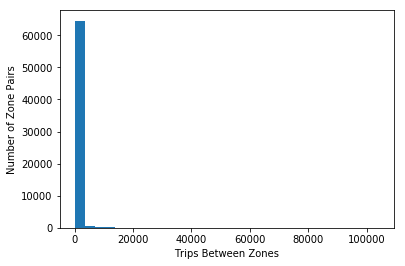

In [17]:
count_trips(df_taxi, df_pairs)
plt.hist(df_pairs.trips, bins=30)
plt.xlabel('Trips Between Zones')
plt.ylabel('Number of Zone Pairs')

#### Visualize Trips

Finding representative points


100%|██████████| 260/260 [00:00<00:00, 1093.80it/s]


Drawing lines


100%|██████████| 65792/65792 [00:34<00:00, 1933.49it/s]


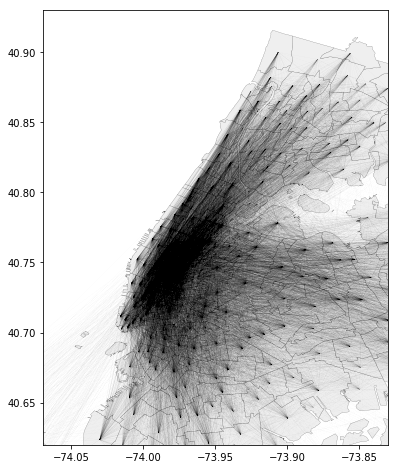

In [18]:
plot_pairs(
    taxi_geo, df_pairs, 'trips',
    label='Trips',
    bounds=(-74.07, -73.83, 40.62, 40.93),
    transform='log')

#### Adding a Threshold

Finding representative points


100%|██████████| 260/260 [00:00<00:00, 1232.10it/s]


Drawing lines


100%|██████████| 65792/65792 [00:00<00:00, 79345.49it/s]


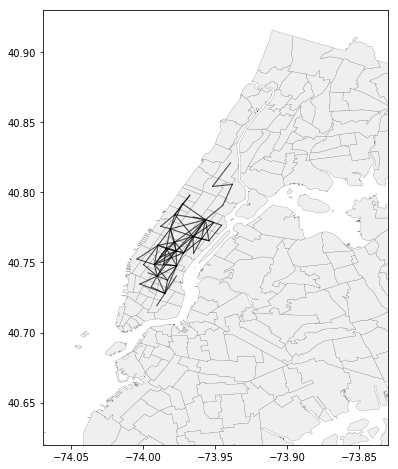

In [19]:
threshold = 20000
plot_pairs(
    taxi_geo, df_pairs, 'trips',
    label='Trips',
    bounds=(-74.07, -73.83, 40.62, 40.93),
    threshold=threshold,
    linewidth=1,
    alpha=0.5,
    transform='log')

#### Calculate Mean Trip Distance

In [20]:
def get_mean_distance(df_taxi, df_pairs):
    print('Finding mean distance')
    # Calculate mean trip distance
    df_mean = df_taxi.groupby(['PULocationID', 'DOLocationID']).mean()
    df_trip = df_mean['trip_distance']
    df_pairs['trip_distance'] = np.zeros(len(df_pairs.index))
    for a_id, b_id in tqdm(df_pairs.index):
        # Get counts in each direction
        ab_count = df_pairs['trips'].get((a_id, b_id), 0)
        ba_count = df_pairs['trips'].get((b_id, a_id), 0)
        # If no trips, average distance is undefined
        if (ab_count + ba_count == 0):
            df_pairs.loc[(a_id, b_id), 'trip_distance'] = float('nan')
        # Otherwise take a weighted average of each direction
        else:
            df_pairs.loc[(a_id, b_id), 'trip_distance'] = (
               ab_count * df_trip.get((a_id, b_id), 0)
                + ba_count * df_trip.get((b_id, a_id), 0)) / (ab_count + ba_count)

In [21]:
get_mean_distance(df_taxi, df_pairs)

Finding mean distance


100%|██████████| 65792/65792 [00:33<00:00, 1991.73it/s]


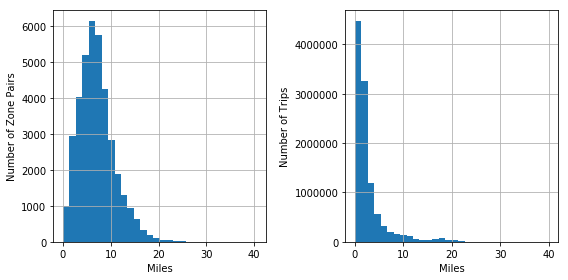

In [22]:
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1);
df_pairs['trip_distance'].hist(bins=30)
plt.xlabel("Miles")
plt.ylabel("Number of Zone Pairs")
plt.subplot(1, 2, 2);
plt.hist(df_taxi[df_taxi['trip_distance'] < 40]['trip_distance'], bins=30)
plt.xlabel("Miles")
plt.ylabel("Number of Trips")
plt.grid()
plt.tight_layout()

#### Compute a map from census tract values to taxi zone

In [23]:
# Helper functions

# Create a function mapping census tract vectors to taxi zone vectors
def get_tract_to_zone(taxi_geo, tract_geo):
    # Get fractions of zone overlapping each tract
    weight_zone_tract, all_zones = get_weight_zone_tract(taxi_geo, tract_geo)
    # Create a function to map census data to taxi zones
    def tract_to_zone(tract_data):
        zone_data = pd.Series(index=list(all_zones))
        for zone_id in tqdm(all_zones):
            zone_data[zone_id] = 0
            for tract_id, d in tract_data.items():
                f = weight_zone_tract[zone_id][tract_id]
                zone_data[zone_id] += f * tract_data[tract_id]
        return zone_data
    # Return function
    return tract_to_zone

# Create a function mapping census tract vectors to taxi zone vectors
def get_weight_zone_tract(taxi_geo, tract_geo):
    
    # Calculate the fraction of each zone that overlaps with a given tract
    weight_zone_tract = {}
    empty_zones = set()
    all_zones = set()
    for zone in tqdm(taxi_geo):
        zone_id = zone.attributes['LocationID']
        all_zones.add(zone_id)
        weight_tract = {}
        for tract in tract_geo:
            tract_id = int(tract.attributes['GEOID'])
            # This is a rough approximation that treats lat/long as cartesian
            f = zone._geometry.intersection(tract._geometry).area / zone._geometry.area
            weight_tract[tract_id] = f
        # Exclude taxi zones without enough data
        zone_total = sum(weight_tract.values())
        if zone_total < 0.5:
            empty_zones.add(zone_id)
        else:
            # Normalize
            for tract_id in weight_tract.keys():
                weight_tract[tract_id] /= zone_total
        weight_zone_tract[zone_id] = weight_tract
    return weight_zone_tract, all_zones


In [24]:
tract_to_zone = get_tract_to_zone(taxi_geo, tract_geo)

100%|██████████| 260/260 [00:30<00:00,  8.42it/s]


#### Taxi Zone Income

In [25]:
zone_incomes = tract_to_zone(df_census['income'])

100%|██████████| 257/257 [00:12<00:00, 20.43it/s]


100%|██████████| 260/260 [00:00<00:00, 77057.59it/s]


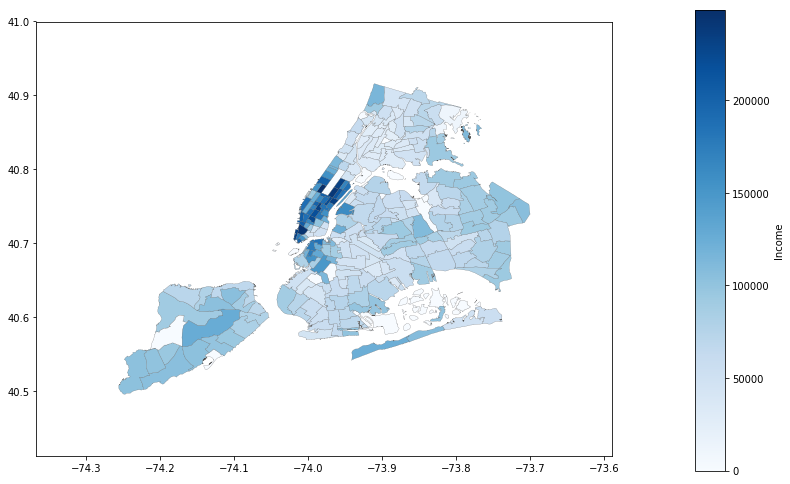

In [26]:
for zone in tqdm(taxi_geo): 
    zone_id = zone.attributes['LocationID']
    zone.attributes['income'] = zone_incomes[zone_id]
plot_geo_values(taxi_geo, 'income', label="Income")

Text(0,0.5,'Number of Zones')

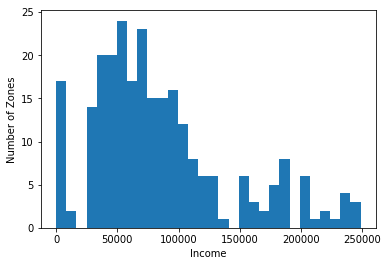

In [27]:
plt.hist(zone_incomes, bins=30)
plt.xlabel('Income')
plt.ylabel('Number of Zones')

#### Income Difference

In [28]:
# Calculate trips vs income difference
def get_income_diff(df_pairs, zone_incomes):
    print('Finding income difference')
    df_pairs['log_income_diff'] = np.zeros(len(df_pairs.index))
    for i, j in tqdm(df_pairs.index):
        a = zone_incomes[i]
        b = zone_incomes[j]
        # Ignore zero case and partial zones
        if a > 25000 and b > 25000:
            df_pairs.loc[(i, j), 'log_income_diff'] = np.log10(b) - np.log10(a)
        else:
            df_pairs.loc[(i, j), 'log_income_diff'] = float('nan')

  1%|          | 523/65792 [00:00<00:12, 5228.48it/s]

Finding income difference


100%|██████████| 65792/65792 [00:13<00:00, 5012.96it/s]


Text(0,0.5,'Number of pairs')

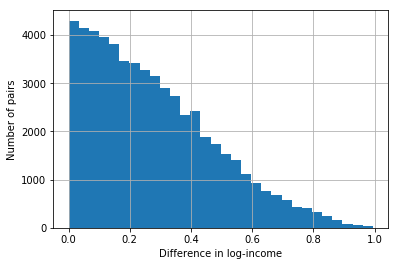

In [29]:
get_income_diff(df_pairs, zone_incomes)
df_pairs['log_income_diff'].abs().hist(bins=30)
plt.xlabel('Difference in log-income')
plt.ylabel('Number of pairs')

#### Comparing income and connectivity

In [30]:
# Helper functions

def plot_binned(x, y, alpha=1, bins=30, log=None, xlabel=None, ylabel=None, title=None):
    # Remove nan
    isnan = np.isnan(x) | np.isnan(y)
    x = np.array(x)[~isnan]
    y = np.array(y)[~isnan]
    num_bins = bins
    low = min(x)
    high = max(x)
    delta = (high - low) / num_bins
    bin_x = [[] for i in range(num_bins)]
    bin_y = [[] for i in range(num_bins)]
    bin_cx = [low + delta * (i + 1/2) for i in range(num_bins)]
    for i in range(len(x)):
        try:
            b = int(math.floor((x[i] - low) / delta))
        except ValueError:
            print(x[i] == 'nan', x[i], low, delta)
            raise
        if b == num_bins:
            # Include edge case on top bin
            b -= 1
        bin_x[b].append(x[i])
        bin_y[b].append(y[i])
    means = np.array([np.mean(by) for by in bin_y])
    std = np.array([np.std(by) for by in bin_y])
    count = np.sqrt(np.array([len(by) for by in bin_y]))
    se = std / count
    plt.fill_between(bin_cx, means - 2 * se, means + 2 * se, color='#dfdfdf', zorder=2, alpha=alpha)
    if log == 'x':
        plt.semilogx(x, y, '.', zorder=1, alpha=0.1)
        plt.semilogx(bin_cx, means)
        plt.semilogx(bin_cx, means - 2 * se, '--', color='#999999')
        plt.semilogx(bin_cx, means + 2 * se, '--', color='#999999')
    elif log == 'y':
        plt.semilogy(x, y, '.', zorder=1, alpha=0.1)
        plt.semilogy(bin_cx, means)
        plt.semilogy(bin_cx, means - 2 * se, '--', color='#999999')
        plt.semilogy(bin_cx, means + 2 * se, '--', color='#999999')
    elif log == 'xy':
        plt.loglog(x, y, '.', zorder=1, alpha=0.1)
        plt.loglog(bin_cx, means)
        plt.loglog(bin_cx, means - 2 * se, '--', color='#999999')
        plt.loglog(bin_cx, means + 2 * se, '--', color='#999999')
    else:
        plt.plot(x, y, '.', zorder=1, alpha=0.1)
        plt.plot(bin_cx, means)
        plt.plot(bin_cx, means - 2 * se, '--', color='#999999')
        plt.plot(bin_cx, means + 2 * se, '--', color='#999999')
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    if title is not None:
        plt.title(title)

    

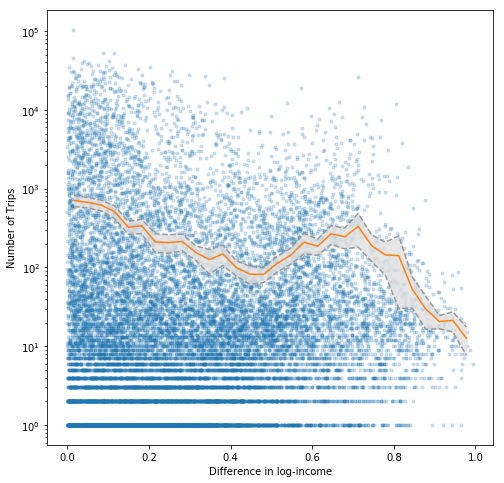

In [31]:
plt.figure(figsize=(8, 8))
plot_binned(
    df_pairs['log_income_diff'].abs(), df_pairs['trips'],
    log='y', alpha=0.8,
    xlabel='Difference in log-income',
    ylabel='Number of Trips')

#### Trip Distance and Connectivity

/Users/elplatt/science3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/elplatt/science3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/elplatt/science3/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/elplatt/science3/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/elplatt/science3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.9, 50000)

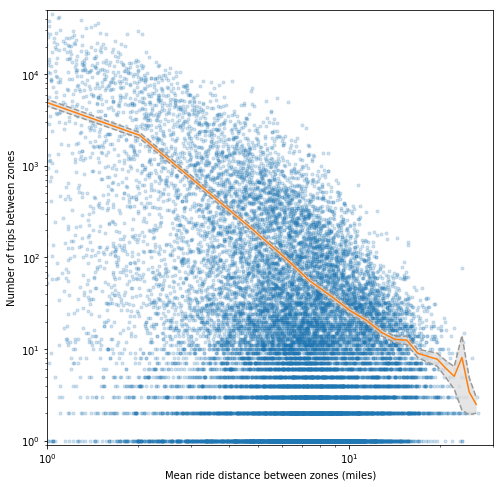

In [32]:
# Calculate trip distance vs income difference
plt.figure(figsize=(8, 8))
plot_binned(
    df_pairs['trip_distance'], df_pairs['trips'],
    log='xy', alpha=0.8,
    xlabel='Mean ride distance between zones (miles)',
    ylabel='Number of trips between zones')
plt.xlim([1, 30])
plt.ylim([0.9, 50000])

#### Fixing Distance

In [33]:
def filter_zones(df_pairs, distance, tolerance):
    df = df_pairs[(df_pairs.trip_distance - distance).abs() < tolerance]
    return df

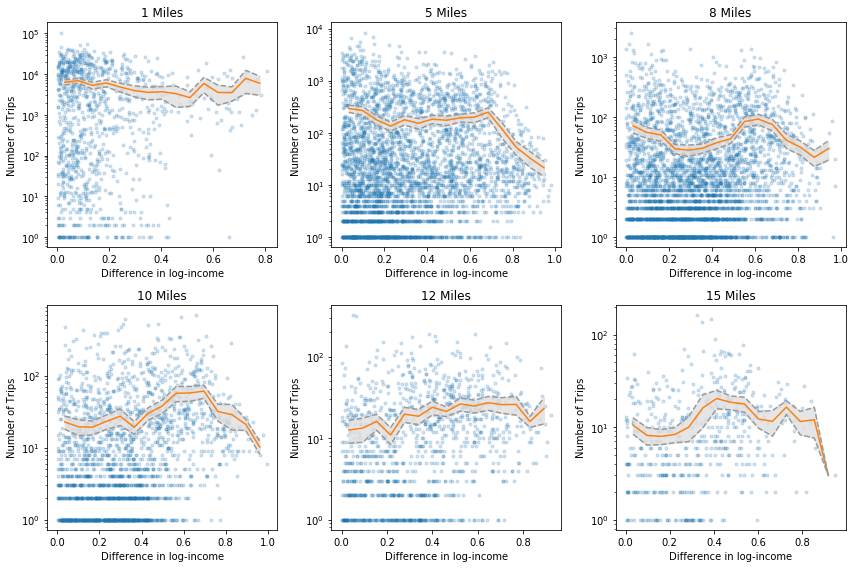

In [34]:
plt.figure(figsize=(12, 8))
for i, miles in enumerate([1, 5, 8, 10, 12, 15]):
    df_pairs_miles = filter_zones(df_pairs, miles, 1)
    plt.subplot(2, 3, i + 1)
    plot_binned(
        df_pairs_miles['log_income_diff'].abs(),
        df_pairs_miles['trips'],
        bins=15, log='y', alpha=0.8,
        xlabel='Difference in log-income',
        ylabel='Number of Trips',
        title='{} Miles'.format(miles))
plt.tight_layout()

#### Selecting based on time

In [42]:
# Helper functions

def get_trip_datetime(df):
    print('Finding trip times')
    weekday = []
    hour = []
    minute = []
    
    for i in tqdm(df.index):
        s = df.loc[i, 'tpep_pickup_datetime']
        dt = datetime.strptime(s, '%Y-%m-%d %H:%M:%S')
        weekday.append(dt.weekday())
        hour.append(dt.hour)
        minute.append(dt.minute)
    
    df['weekday'] = weekday
    df['hour'] = hour
    df['minute'] = minute

In [43]:
df = pd.DataFrame(df_taxi[~df_taxi.index.duplicated(keep='first')])
get_trip_datetime(df)

  0%|          | 0/9710124 [00:00<?, ?it/s]

Finding trip times


100%|██████████| 9710124/9710124 [06:21<00:00, 25459.79it/s]


In [48]:
df_rushhour = df[
    (df.weekday < 5)
    & ((df.hour >= 6) & (df.hour < 10)
       | ((df.hour >= 15) & (df.hour < 19)))]

In [49]:
df_weekend = df[
    (df.weekday > 4)
    & (df.hour >= 10) & (df.hour < 15)]

In [51]:
# Calculate pair stats for weekend
df_pairs_weekend = make_pair_df(taxi_geo)
count_trips(df_weekend, df_pairs_weekend)
get_mean_distance(df_weekend, df_pairs_weekend)
get_income_diff(df_pairs_weekend, zone_incomes)

# Calculate pair stats for weekday rush hour
df_pairs_rush = make_pair_df(taxi_geo)
count_trips(df_rushhour, df_pairs_rush)
get_mean_distance(df_rushhour, df_pairs_rush)
get_income_diff(df_pairs_rush, zone_incomes)

Counting trips


100%|██████████| 65792/65792 [00:54<00:00, 1200.88it/s]


Finding mean distance


  1%|          | 480/65792 [00:00<00:13, 4794.20it/s]

Finding income difference


100%|██████████| 65792/65792 [00:13<00:00, 4890.11it/s]


Counting trips


100%|██████████| 65792/65792 [00:52<00:00, 1257.52it/s]


Finding mean distance


  1%|          | 490/65792 [00:00<00:13, 4893.01it/s]

Finding income difference


100%|██████████| 65792/65792 [00:13<00:00, 4991.68it/s]


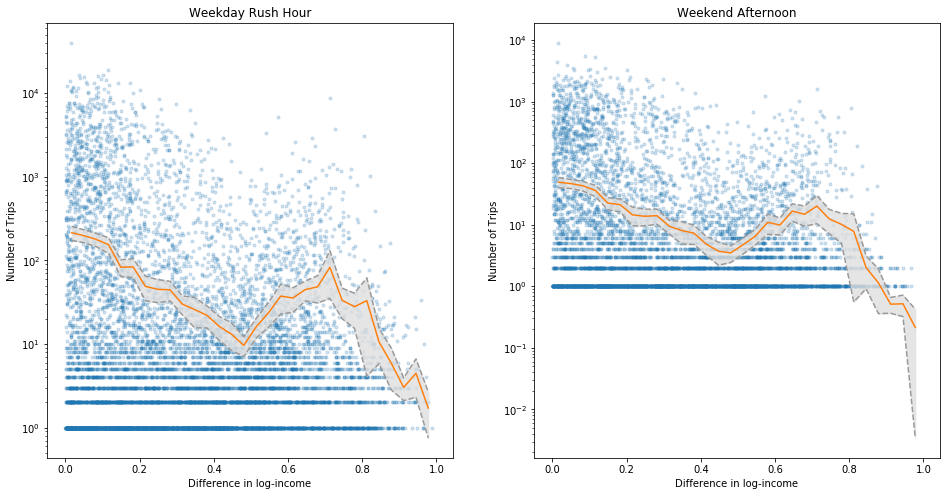

In [52]:
plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plot_binned(
    df_pairs_rush['log_income_diff'].abs(), df_pairs_rush['trips'],
    log='y', alpha=0.8,
    xlabel='Difference in log-income',
    ylabel='Number of Trips',
    title='Weekday Rush Hour')
plt.subplot(1,2,2)
plot_binned(
    df_pairs_weekend['log_income_diff'].abs(), df_pairs_weekend['trips'],
    log='y', alpha=0.8,
    xlabel='Difference in log-income',
    ylabel='Number of Trips',
    title='Weekend Afternoon')


In [53]:
df_pairs_weekend[(df_pairs_weekend.log_income_diff - 0.7).abs() < 0.05].sort_values('trips', ascending=False).head()

,trips,trip_distance,log_income_diff
"(75, 236)",1611.0,0.938740,0.712990
"(74, 263)",1019.0,1.691117,0.664505
"(148, 234)",715.0,1.939500,0.721033
"(148, 249)",670.0,1.631533,0.653659
"(75, 237)",617.0,1.793119,0.727078


In [54]:
taxi_geo[73]

<Record: <shapely.geometry.polygon.Polygon object at 0x10fe8cf98>, {'OBJECTID': 75, 'Shape_Leng': 0.0876638997685, 'Shape_Area': 0.00024056392715, 'zone': 'East Harlem South', 'LocationID': 75, 'borough': 'Manhattan', 'pickups': 120844, 'dropoffs': 136533, 'income': 45084.33293351601}, <fields>>

In [55]:
taxi_geo[232]

<Record: <shapely.geometry.polygon.Polygon object at 0x125da1cf8>, {'OBJECTID': 236, 'Shape_Leng': 0.0442519223099, 'Shape_Area': 0.000102864345211, 'zone': 'Upper East Side North', 'LocationID': 236, 'borough': 'Manhattan', 'pickups': 366054, 'dropoffs': 387300, 'income': 232817.72621901685}, <fields>>

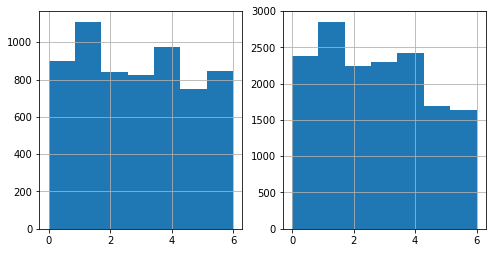

In [66]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
df[(df.PULocationID == 75) & (df.DOLocationID == 236)]['weekday'].hist(bins=7)
plt.subplot(1,2,2)
df[(df.PULocationID == 236) & (df.DOLocationID == 75)]['weekday'].hist(bins=7)

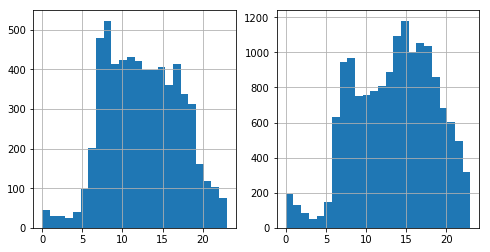

In [67]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
df[(df.PULocationID == 75) & (df.DOLocationID == 236)]['hour'].hist(bins=24)
plt.subplot(1,2,2)
df[(df.PULocationID == 236) & (df.DOLocationID == 75)]['hour'].hist(bins=24)